In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

from pprint import pprint

In [2]:
#load weather data
from weather_collection import WeatherDatum
weather = pickle.load(open('LargeDataStorage/weatherDataFile', 'rb'))

#load hubway data
hubway = pickle.load(open('LargeDataStorage/hubwayDataFile', 'rb'))

In [21]:
def count_riders(year, month, day, hour):
	"""
	Input: year, month, day, hour
	Output: total riders during that hour
	"""

	#initialize counter
	counter = 0

	#counts riders during a given hour
	for minute in range(0,60):
		#-1 means that there is no data for that time, so we don't count that
		if hubway.data[year][month][day+1][hour][minute] == -1:
			pass
		else:
			counter += len(hubway.data[year][month][day+1][hour][minute])
	return counter

In [4]:
def process_data(year):
    """
    Returns 2 lists, 1 of temperatures, 1 of associated ridership.
    """

    #determines whether or not it is a leap year
    if year % 4 == 0:
        numDaysInMonth = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    else:
        numDaysInMonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    riders_vs_temp = {}

    #adds all hourly temperatures in given year to dictionary as keys with values of 0
    for m in range(1,13):
        for d in range(numDaysInMonth[m-1]):
            for h in range(0,24):
                if int(float(weather.data[year][m][d+1][h]['tempi'])) < -100:
                    pass
                else:
                    riders_vs_temp[int(float(weather.data[year][m][d+1][h]['tempi']))] = 0

    #adds number of riders to associated temperature in the dictionary
    for month in range(1,13):
        for day in range(numDaysInMonth[month-1]):
            for hour in range(24):
                if int(float(weather.data[year][month][day+1][hour]['tempi'])) < -100:
                    pass
                else:
                    riders_vs_temp[int(float(weather.data[year][month][day+1][hour]['tempi']))] += count_riders(year, month, day, hour)

    return riders_vs_temp.keys(), riders_vs_temp.values()

In [6]:
"""
Straight up linear regression by taking the log of data.
"""

def lin_reg(year):
    
    # import temperature and ridership data
    temperatures, ridership = process_data(year)
    
    # turn data into array
    temps = np.array(temperatures)
    rides = np.array(ridership)
    
    # remove negative values so that np.log will not return NaN
    for i in range(len(temps)):
        if temps[i] < 0:
            temps = np.delete(temps, i)
            rides = np.delete(rides, i)
    
    # take the log of the data so that you can use a linear regression
    temps = np.log(temps)
    rides = np.log(rides)
    
    # removes infinity from log and sets to 0
    for i in range(len(rides)):
        if rides[i] == -np.inf:
            rides[i] = 0
    
    for i in range(len(temps)):
        if temps[i] == -np.inf:
            temps[i] = 0
            
    # make array vertical so that scikit-learn can process it
    temps = temps.reshape(temps.shape[0], -1)
    rides = rides.reshape(rides.shape[0], -1)
    
    X_train, X_test, y_train, y_test = train_test_split(temps, rides, train_size=0.5)

    model = LinearRegression()
    model.fit(X_train, y_train)
    print year
    print "Train R2 %f"%model.score(X_train, y_train)
    print "Test R2 %f"%model.score(X_test, y_test)

lin_reg(2011)
lin_reg(2012)
lin_reg(2013)

2011
Train R2 0.421231
Test R2 -0.024923
2012
Train R2 0.792303
Test R2 0.586453
2013
Train R2 0.698565
Test R2 0.714665


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log


Year 2011, 3 degree polynomial regression
Train R2 0.648147
Test R2 0.546879


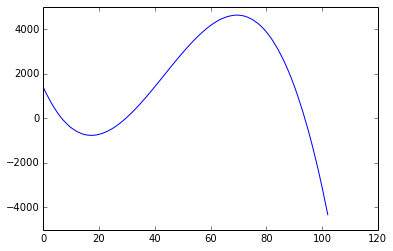

Year 2011, 4 degree polynomial regression
Train R2 0.650541
Test R2 0.562286


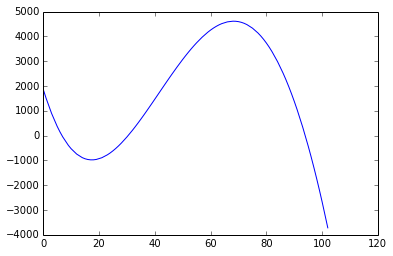

Year 2011, 5 degree polynomial regression
Train R2 0.729090
Test R2 0.727654


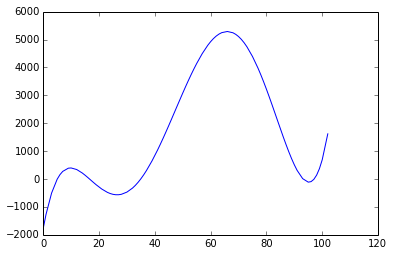

Year 2011, 6 degree polynomial regression
Train R2 0.732869
Test R2 0.712600


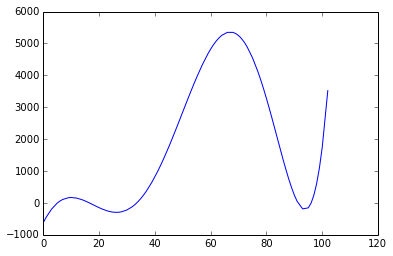

Year 2011, 7 degree polynomial regression
Train R2 0.743379
Test R2 0.743763


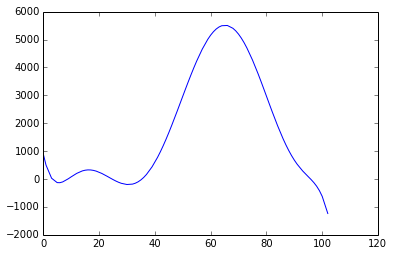

Year 2011, 8 degree polynomial regression
Train R2 0.744418
Test R2 0.641783


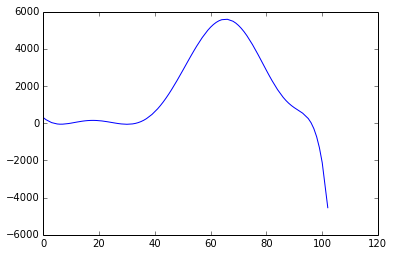

Year 2011, 9 degree polynomial regression
Train R2 0.750324
Test R2 0.654334


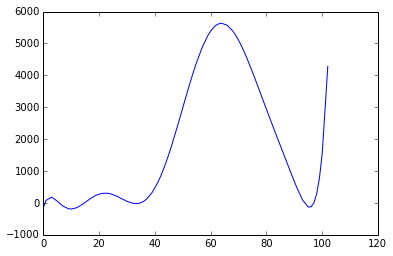

Year 2011, 10 degree polynomial regression
Train R2 0.754242
Test R2 0.518923


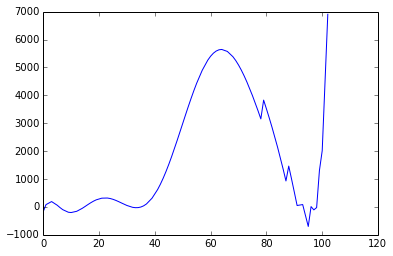

Year 2012, 3 degree polynomial regression
Train R2 0.702450
Test R2 0.707016


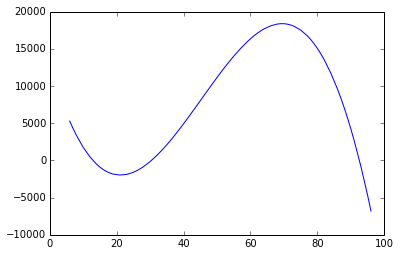

Year 2012, 4 degree polynomial regression
Train R2 0.708526
Test R2 0.691069


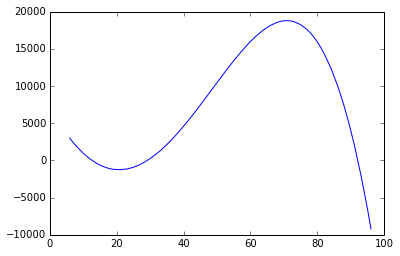

Year 2012, 5 degree polynomial regression
Train R2 0.750687
Test R2 0.741479


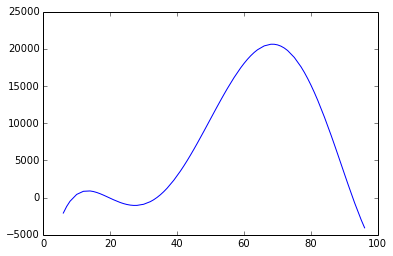

Year 2012, 6 degree polynomial regression
Train R2 0.784962
Test R2 0.708067


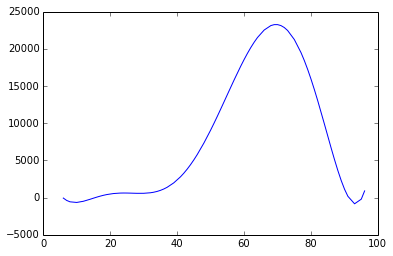

Year 2012, 7 degree polynomial regression
Train R2 0.794329
Test R2 0.678898


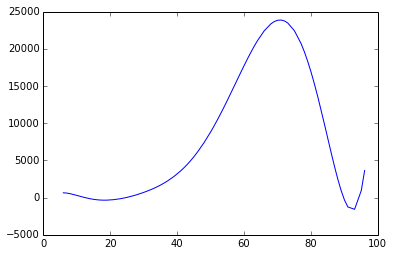

Year 2012, 8 degree polynomial regression
Train R2 0.795117
Test R2 0.673821


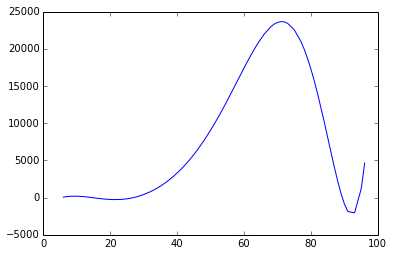

Year 2012, 9 degree polynomial regression
Train R2 0.799550
Test R2 0.667579


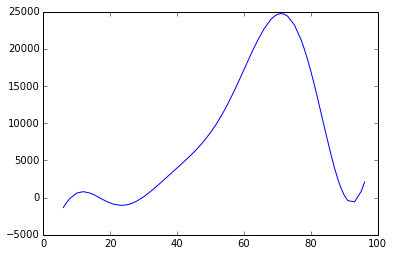

Year 2012, 10 degree polynomial regression
Train R2 0.818325
Test R2 0.531161


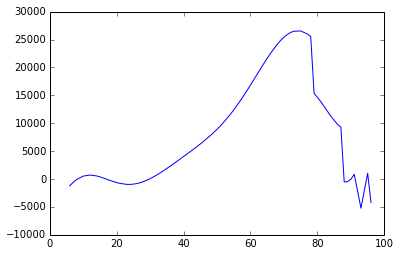

Year 2013, 3 degree polynomial regression
Train R2 0.635555
Test R2 0.761798


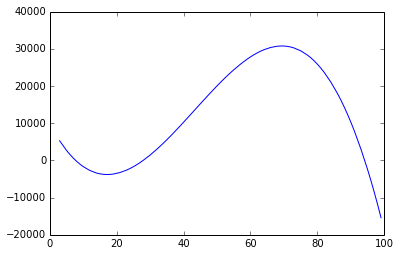

Year 2013, 4 degree polynomial regression
Train R2 0.643243
Test R2 0.751951


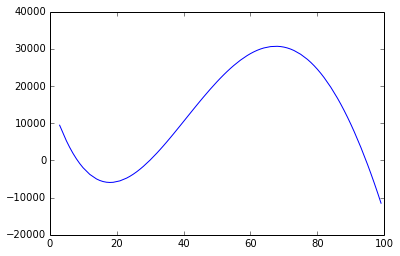

Year 2013, 5 degree polynomial regression
Train R2 0.728206
Test R2 0.832029


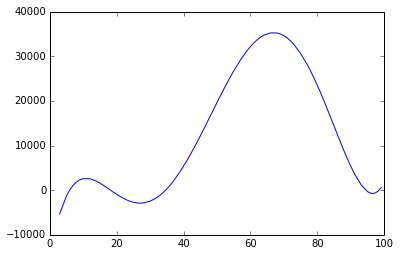

Year 2013, 6 degree polynomial regression
Train R2 0.732906
Test R2 0.852562


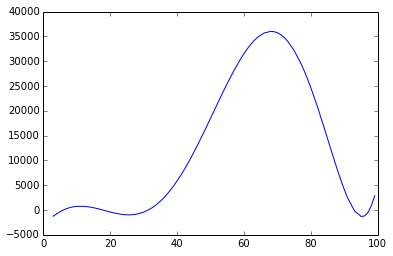

Year 2013, 7 degree polynomial regression
Train R2 0.735746
Test R2 0.857614


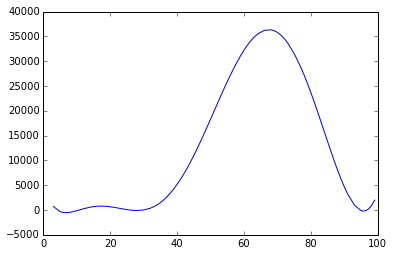

Year 2013, 8 degree polynomial regression
Train R2 0.740251
Test R2 0.859109


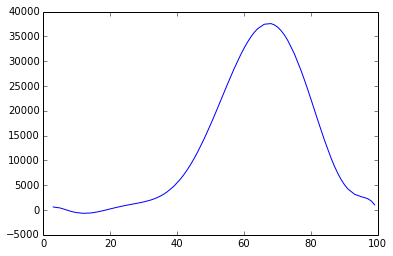

Year 2013, 9 degree polynomial regression
Train R2 0.743829
Test R2 0.840908


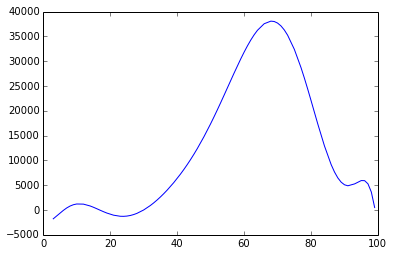

Year 2013, 10 degree polynomial regression
Train R2 0.752890
Test R2 0.791865


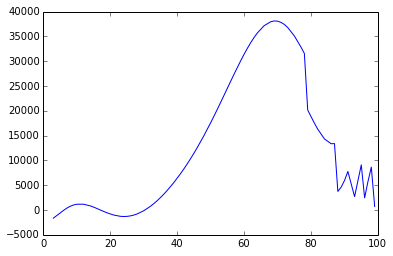

In [5]:
"""
Running a linear regression after transforming a polynomial 
into multiple coefficients so that a linear regression will work
"""

def lin_reg(year):
    
    # import temperature and ridership data
    temperatures, ridership = process_data(year)
    
    # turn data into array
    temps = np.array(temperatures)
    rides = np.array(ridership)

    # remove negative values so that np.log will not return NaN
    for i in range(len(temps)):
        if temps[i] < 0:
            temps = np.delete(temps, i)
            rides = np.delete(rides, i)

    # make array vertical so that scikit-learn can process it
    temps = temps.reshape(temps.shape[0], -1)
    rides = rides.reshape(rides.shape[0], -1)
    
    X_train, X_test, y_train, y_test = train_test_split(temps, rides, train_size=0.5)
    
    for degrees in range(3, 11):
        model = make_pipeline(PolynomialFeatures(degrees), Ridge())

        model.fit(X_train, y_train)
        print "Year %d, %d degree polynomial regression" % (year, degrees)
        print "Train R2 %f"%model.score(X_train, y_train)
        print "Test R2 %f"%model.score(X_test, y_test)

        y_plot = model.predict(temps)
        plt.plot(temps, y_plot)
        plt.show()

lin_reg(2011)
lin_reg(2012)
lin_reg(2013)

In [21]:
"""
Using a Support Vector Regression (a type of Support Vector Machine)
"""

def sup_vec(year):
        
    # import temperature and ridership data
    temperatures, ridership = process_data(year)
    
    # turn data into array
    temps = np.array(temperatures)
    rides = np.array(ridership)

    # remove negative values so that np.log will not return NaN
    for i in range(len(temps)):
        if temps[i] < 0:
            temps = np.delete(temps, i)
            rides = np.delete(rides, i)

    # make array vertical so that scikit-learn can process it
    temps = temps.reshape(temps.shape[0], -1)
    rides = rides.reshape(rides.shape[0], -1)
    
    X_train, X_test, y_train, y_test = train_test_split(temps, rides, train_size=0.5)
    
    model = SVR()
    model.fit(X_train, y_train, sample_weight=None)
    print year
    print "Train R2 %f"%model.score(X_train, y_train)
    print "Test R2 %f"%model.score(X_test, y_test)

sup_vec(2011)
sup_vec(2012)
sup_vec(2013)

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [27]:
def count_riders2(year, month, day, hour):
	"""
	Input: year, month, day, hour
	Output: total riders during that hour
	"""

	#initialize counter
	counter = 0

	#counts riders during a given hour
	for minute in range(0,60):
		#-1 means that there is no data for that time, so we don't count that
		if hubway.data[year][month][day][hour][minute] == -1:
			pass
		else:
			counter += len(hubway.data[year][month][day][hour][minute])
	return counter

In [42]:
def process_data2():
    """
    Warning: hard-coded for hubway data from 2013
    Output: Array formatted array([year, month, day, hour, temp, precip, snow*, riders])
    Note: * data is binary, units are in imperial (english) units
    """
    
    year = 2013
    
    # not a leap year, also taking into account dates hubway was open
    # 2013 start = 4/2/2013
    # 2013 end = 11/30/2013
    numDaysInMonth = [29, 31, 30, 31, 31, 30, 31, 30]
    
    # initalize main list for data
    all_data = []
    
    for index in range(sum(numDaysInMonth)):
        # initalize list that will be appended to all_data
        curr_list = [year]

        for month in range(4, 6):
            for day in range(numDaysInMonth[month-4]):
                for hour in range(0,24):
                    # this is here to make sure that data for April starts on the 2nd
                    if month == 4:
                        tempi = int(float(weather.data[year][month][day+2][hour]['tempi']))
                        if int(float(weather.data[year][month][day+2][hour]['precipi'])) < 0:
                            precipi = 0
                        else: 
                            precipi = int(float(weather.data[year][month][day+2][hour]['precipi']))
                        snow = int(weather.data[year][month][day+2][hour]['snow'])
                        riders = count_riders2(year, month, day+2, hour)
                        curr_list = [year, month, day+2, hour, tempi, precipi, snow, riders]
                        all_data.append(curr_list)
                    else:
                        tempi = int(float(weather.data[year][month][day+1][hour]['tempi']))
                        if int(float(weather.data[year][month][day+1][hour]['precipi'])) < 0:
                            precipi = 0
                        else:
                            precipi = int(float(weather.data[year][month][day+1][hour]['precipi']))
                        snow = int(weather.data[year][month][day+1][hour]['snow'])
                        riders = count_riders2(year, month, day+1, hour)
                        curr_list = [year, month, day+1, hour, tempi, precipi, snow, riders]
                        all_data.append(curr_list)
    
    return np.array(all_data)

In [43]:
data_array = process_data2()

In [50]:
# print data_array
# for i in range(8):
#     print data_array[:,i]
print data_array[:,[1,2,3,4,5,6]]

[[ 4  2  0 35  0  0]
 [ 4  2  1 35  0  0]
 [ 4  2  2 34  0  0]
 ..., 
 [ 5 31 21 84  0  0]
 [ 5 31 22 82  0  0]
 [ 5 31 23 80  0  0]]


Year 2013, 3 degree polynomial regression
Train R2 0.181979
Test R2 0.182250


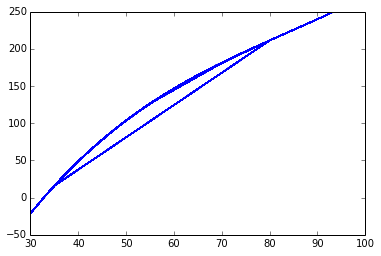

KeyboardInterrupt: 

In [45]:
"""
Running a linear regression after transforming a polynomial 
into multiple coefficients so that a linear regression will work
"""

def lin_reg():
    
    year = 2013
    
    # import temperature and ridership data
#     data_array = process_data2()
    
    X = data_array[:,4]
    Y = data_array[:,7]
    
    # make array vertical so that scikit-learn can process it
    X = X.reshape(X.shape[0], -1)
    Y = Y.reshape(Y.shape[0], -1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5)
    
    for degrees in range(3, 11):
        model = make_pipeline(PolynomialFeatures(degrees), Ridge())

        model.fit(X_train, y_train)
        print "Year %d, %d degree polynomial regression" % (year, degrees)
        print "Train R2 %f"%model.score(X_train, y_train)
        print "Test R2 %f"%model.score(X_test, y_test)

        y_plot = model.predict(X)
        plt.plot(X, y_plot)
        plt.show()

lin_reg()

In [48]:
"""
Running a linear regression after transforming a polynomial 
into multiple coefficients so that a linear regression will work
"""

def lin_reg():
    
    year = 2013
    
    # import temperature and ridership data
#     data_array = process_data2()
    
    X = data_array[:,3]
    Y = data_array[:,7]

    # make array vertical so that scikit-learn can process it
    X = X.reshape(X.shape[0], -1)
    Y = Y.reshape(Y.shape[0], -1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5)
    
    for degrees in range(3, 11):
        model = make_pipeline(PolynomialFeatures(degrees), Ridge())

        model.fit(X_train, y_train)
        print "Year %d, %d degree polynomial regression" % (year, degrees)
        print "Train R2 %f"%model.score(X_train, y_train)
        print "Test R2 %f"%model.score(X_test, y_test)

#         y_plot = model.predict(X)
#         plt.plot(X, y_plot)
#         plt.show()

lin_reg()

Year 2013, 3 degree polynomial regression
Train R2 0.453566
Test R2 0.453791
Year 2013, 4 degree polynomial regression
Train R2 0.454072
Test R2 0.454275
Year 2013, 5 degree polynomial regression
Train R2 0.454705
Test R2 0.454971
Year 2013, 6 degree polynomial regression
Train R2 0.488657
Test R2 0.489850
Year 2013, 7 degree polynomial regression
Train R2 0.520483
Test R2 0.522616
Year 2013, 8 degree polynomial regression
Train R2 0.546739
Test R2 0.549453
Year 2013, 9 degree polynomial regression
Train R2 0.563604
Test R2 0.567007
Year 2013, 10 degree polynomial regression
Train R2 0.564429
Test R2 0.568010


In [ ]:
"""
Running a linear regression after transforming a polynomial 
into multiple coefficients so that a linear regression will work
"""

def lin_reg():
    
    year = 2013
    
    # import temperature and ridership data
#     data_array = process_data2()
    
    X = data_array[:,5]
    Y = data_array[:,7]
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5)
    
    for degrees in range(3, 11):
        model = make_pipeline(PolynomialFeatures(degrees), Ridge())

        model.fit(X_train, y_train)
        print "Year %d, %d degree polynomial regression" % (year, degrees)
        print "Train R2 %f"%model.score(X_train, y_train)
        print "Test R2 %f"%model.score(X_test, y_test)

        y_plot = model.predict(X)
        plt.plot(X, y_plot)
        plt.show()

lin_reg()

In [ ]:
"""
Running a linear regression after transforming a polynomial 
into multiple coefficients so that a linear regression will work
"""

def lin_reg():
    
    year = 2013
    
    # import temperature and ridership data
#     data_array = process_data2()
    
    X = data_array[:,6]
    Y = data_array[:,7]
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5)
    
    for degrees in range(3, 11):
        model = make_pipeline(PolynomialFeatures(degrees), Ridge())

        model.fit(X_train, y_train)
        print "Year %d, %d degree polynomial regression" % (year, degrees)
        print "Train R2 %f"%model.score(X_train, y_train)
        print "Test R2 %f"%model.score(X_test, y_test)

        y_plot = model.predict(X)
        plt.plot(X, y_plot)
        plt.show()

lin_reg()

In [53]:
"""
Running a linear regression after transforming a polynomial 
into multiple coefficients so that a linear regression will work
"""

def lin_reg():
    
    year = 2013
    
    # import temperature and ridership data
#     data_array = process_data2()
    
    X = data_array[:,[1,2,3,4,5,6]]
    Y = data_array[:,7]

    # make array vertical so that scikit-learn can process it
    X = X.reshape(X.shape[0], -1)
    Y = Y.reshape(Y.shape[0], -1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5)
    
    for degrees in range(6, 11):
        model = make_pipeline(PolynomialFeatures(degrees), Ridge())

        model.fit(X_train, y_train)
        print "Year %d, %d degree polynomial regression" % (year, degrees)
        print "Train R2 %f"%model.score(X_train, y_train)
        print "Test R2 %f"%model.score(X_test, y_test)

#         y_plot = model.predict(X)
#         plt.plot(X, y_plot)
#         plt.show()

lin_reg()

MemoryError: 